In [1]:
import torch as pt
import torchvision
from torchinfo import summary 
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

C:\Users\pwrxn\miniconda3\envs\pytorch\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Getting data

In [2]:
from going_modular import data_setup, engine
from helper_functions import download_data, plot_loss_curves
# Download pizza, steak, sushi images from GitHub
data_20_percent_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip",
                                     destination="pizza_steak_sushi_20_percent")

data_20_percent_path

[INFO] data\pizza_steak_sushi_20_percent directory exists, skipping download.


WindowsPath('data/pizza_steak_sushi_20_percent')

In [3]:
# Setup train and test directories
train_dir = data_20_percent_path / 'train'
test_dir = data_20_percent_path / 'test'

## Creating an EffNetB2 feature extractor 

In [4]:
# Setup pretrained EffNetB2 Weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # Best available weights

# get effnetb2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# setup pretrained model instance 
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights)

# Freeze the base layers
for param in effnetb2.parameters():
    param.requires_grad = False

In [5]:
effnetb2

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [6]:
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [7]:
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True),
    nn.Linear(in_features=1408, # keep in_features same 
              out_features=3))

## Creating a function to make an EffNetB2 feature extractor

In [8]:
def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):

    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    pt.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408,
                  out_features=num_classes)
    )
    return model, transforms

In [9]:
# Print EffNetB2 model summary (uncomment for full output) 
summary(effnetb2, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## Creating DataLoaders for EFfNetB2

In [10]:
# Setup DataLoaders
from going_modular import data_setup
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)

In [11]:
from going_modular import engine

loss_fn = nn.CrossEntropyLoss()

optimizer = pt.optim.Adam(params=effnetb2.parameters(), lr=1e-3)

pt.manual_seed(42)
effnetb2_results = engine.train(model=effnetb2,
                                train_dataloader=train_dataloader_effnetb2,
                                test_dataloader=test_dataloader_effnetb2,
                                epochs=10,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                device='cpu')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9909 | train_acc: 0.5479 | test_loss: 0.7560 | test_acc: 0.9199
Epoch: 2 | train_loss: 0.6931 | train_acc: 0.8812 | test_loss: 0.6242 | test_acc: 0.9193
Epoch: 3 | train_loss: 0.5698 | train_acc: 0.8833 | test_loss: 0.5050 | test_acc: 0.9193
Epoch: 4 | train_loss: 0.4730 | train_acc: 0.8667 | test_loss: 0.4409 | test_acc: 0.9318
Epoch: 5 | train_loss: 0.4337 | train_acc: 0.8917 | test_loss: 0.3923 | test_acc: 0.9318
Epoch: 6 | train_loss: 0.3889 | train_acc: 0.8896 | test_loss: 0.3612 | test_acc: 0.9381
Epoch: 7 | train_loss: 0.3413 | train_acc: 0.9062 | test_loss: 0.3261 | test_acc: 0.9443
Epoch: 8 | train_loss: 0.3235 | train_acc: 0.9375 | test_loss: 0.3152 | test_acc: 0.9347
Epoch: 9 | train_loss: 0.3685 | train_acc: 0.8583 | test_loss: 0.2896 | test_acc: 0.9381
Epoch: 10 | train_loss: 0.2563 | train_acc: 0.9479 | test_loss: 0.2765 | test_acc: 0.9506


## Inspecting EffNetB2 Loss Curves

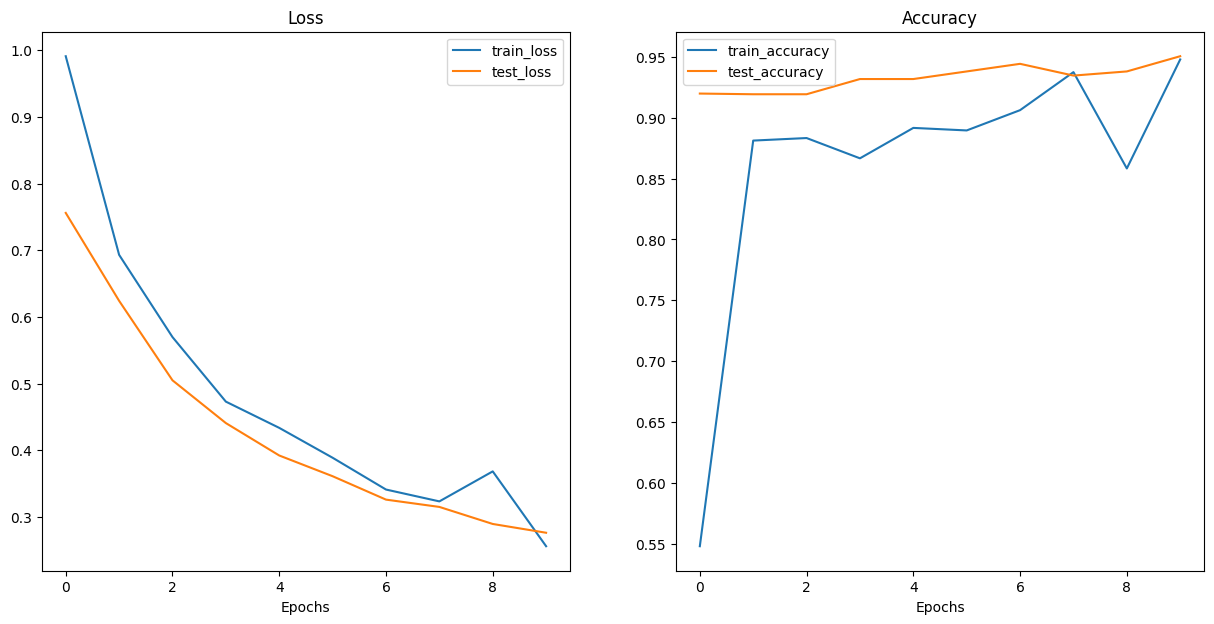

In [12]:
plot_loss_curves(effnetb2_results)

## Saving EffNEtB2 feature extractor

In [13]:
from going_modular import utils

utils.save_model(model=effnetb2,
                 target_dir='models',
                 model_name='MLOps_effnetb2_pizza_steak_sushi.pth')

[INFO] Saving model to: models\MLOps_effnetb2_pizza_steak_sushi.pth


## Inspecting the size of the EffNetB2 feature extractor

In [14]:
from pathlib import Path

pretrained_effnetb2_model_size = Path('models/MLOps_effnetb2_pizza_steak_sushi.pth').stat().st_size / (1024 * 1024)
print(f'Pretrained EffNetB2 feature extractor model size: {round(pretrained_effnetb2_model_size, 2)} MB')

Pretrained EffNetB2 feature extractor model size: 29.83 MB


## Collecting EffNetB2 feature extractor stats

In [15]:
effnetb2_total_params = sum(pt.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [16]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.27646697163581846,
 'test_acc': 0.9505681818181818,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8309268951416}

## Creating a ViT feature extractor

In [17]:
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [18]:
def create_vit_model(num_classes:int=3, 
                     seed:int=42):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.
        seed (int, optional): random seed value for output layer. Defaults to 42.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model. 
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head to suit our needs (this will be trainable)
    pt.manual_seed(seed)
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as original model
                                          out_features=num_classes)) # update to reflect target number of classes
    
    return model, transforms

In [19]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3,
                                       seed=42)

In [20]:
# Print ViT feature extractor model summary (uncomment for full output)
summary(vit, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [21]:
# Setup ViT DataLoaders
from going_modular import data_setup
train_dataloader_vit, test_dataloader_vit, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)

In [22]:
from going_modular import engine

# Setup optimizer
optimizer = pt.optim.Adam(params=vit.parameters(),
                             lr=1e-3)
# Setup loss function
loss_fn = nn.CrossEntropyLoss()

# Train ViT model with seeds set for reproducibility
pt.manual_seed(42)
vit_results = engine.train(model=vit,
                           train_dataloader=train_dataloader_vit,
                           test_dataloader=test_dataloader_vit,
                           epochs=10,
                           optimizer=optimizer,
                           loss_fn=loss_fn,
                           device='cpu')

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7023 | train_acc: 0.7500 | test_loss: 0.2714 | test_acc: 0.9290
Epoch: 2 | train_loss: 0.2531 | train_acc: 0.9104 | test_loss: 0.1669 | test_acc: 0.9602
Epoch: 3 | train_loss: 0.1766 | train_acc: 0.9542 | test_loss: 0.1270 | test_acc: 0.9693
Epoch: 4 | train_loss: 0.1277 | train_acc: 0.9625 | test_loss: 0.1072 | test_acc: 0.9722
Epoch: 5 | train_loss: 0.1163 | train_acc: 0.9646 | test_loss: 0.0950 | test_acc: 0.9784
Epoch: 6 | train_loss: 0.1270 | train_acc: 0.9375 | test_loss: 0.0830 | test_acc: 0.9722
Epoch: 7 | train_loss: 0.0899 | train_acc: 0.9771 | test_loss: 0.0844 | test_acc: 0.9784
Epoch: 8 | train_loss: 0.0928 | train_acc: 0.9812 | test_loss: 0.0759 | test_acc: 0.9722
Epoch: 9 | train_loss: 0.0933 | train_acc: 0.9792 | test_loss: 0.0729 | test_acc: 0.9784
Epoch: 10 | train_loss: 0.0662 | train_acc: 0.9833 | test_loss: 0.0642 | test_acc: 0.9847


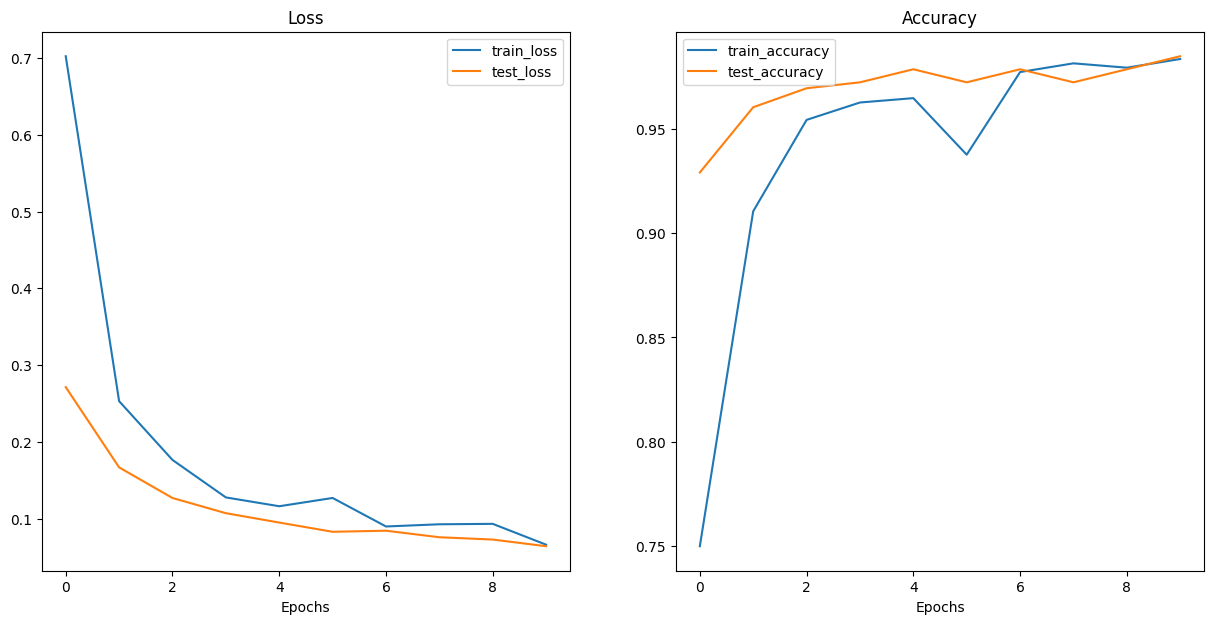

In [23]:
plot_loss_curves(vit_results)

In [24]:
# Saving a vit model
utils.save_model(model=vit,
                 target_dir="models",
                 model_name="MLOps_vit_feature_extractor_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models\MLOps_vit_feature_extractor_pizza_steak_sushi_20_percent.pth


## Checking the size of ViT feature extractor

In [25]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/MLOps_vit_feature_extractor_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly) 
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")

Pretrained ViT feature extractor model size: 327 MB


In [26]:
# Count number of parameters in ViT
vit_total_params = sum(pt.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [27]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.06418203837238252,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

## Making predictions with trained models

In [28]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data\pizza_steak_sushi_20_percent\test


[WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1067986.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1315645.jpg')]

## Creating a function to make predictions across the test datasets

In [29]:
import pathlib
from PIL import Image
from timeit import default_timer as timer 
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability and prediction time
def pred_and_store(paths: List[pathlib.Path], 
                   model: nn.Module,
                   transform: torchvision.transforms, 
                   class_names: List[str], 
                   device: str = "cuda" if pt.cuda.is_available() else "cpu") -> List[Dict]:
    
    # 2. Create an empty list to store prediction dictionaires
    pred_list = []
    
    # 3. Loop through target paths
    for path in tqdm(paths):
        
        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name
        
        # 6. Start the prediction timer
        start_time = timer()
        
        # 7. Open image path
        img = Image.open(path)
        
        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device) 
        
        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()
        
        # 10. Get prediction probability, predicition label and prediction class
        with pt.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample 
            pred_prob = pt.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = pt.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction label
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on) 
            pred_dict["pred_prob"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class
            
            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time-start_time, 4)

        # 13. Does the pred match the true label?
        pred_dict["correct"] = class_name == pred_class

        # 14. Add the dictionary to the list of preds
        pred_list.append(pred_dict)
    
    # 15. Return list of prediction dictionaries
    return pred_list

## Making predictions

In [30]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU 

  0%|          | 0/150 [00:00<?, ?it/s]

In [31]:
# Inspect the first 2 prediction dictionaries
effnetb2_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9932,
  'pred_class': 'pizza',
  'time_for_pred': 0.1464,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.4461,
  'pred_class': 'pizza',
  'time_for_pred': 0.083,
  'correct': True}]

In [32]:
# Turn the test_pred_dicts into a DataFrame
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9932,pizza,0.1464,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.4461,pizza,0.0830,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9938,pizza,0.0811,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.6547,pizza,0.0814,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.7241,pizza,0.0796,True


In [33]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

correct
True     143
False      7
Name: count, dtype: int64

## Predicting time

In [34]:
# Find the average time per prediction 
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.0833 seconds


In [35]:
# Add EffNetB2 average prediction time to stats dictionary 
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.27646697163581846,
 'test_acc': 0.9505681818181818,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29.8309268951416,
 'time_per_pred_cpu': 0.0833}

## Making and timing predictions with ViT

In [36]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [37]:
# Check the first couple of ViT predictions on the test dataset
vit_test_pred_dicts[:2]

[{'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1001116.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9986,
  'pred_class': 'pizza',
  'time_for_pred': 0.392,
  'correct': True},
 {'image_path': WindowsPath('data/pizza_steak_sushi_20_percent/test/pizza/1032754.jpg'),
  'class_name': 'pizza',
  'pred_prob': 0.9957,
  'pred_class': 'pizza',
  'time_for_pred': 0.3825,
  'correct': True}]

In [38]:
# Turn vit_test_pred_dicts into a DataFrame
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_prob,pred_class,time_for_pred,correct
0,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9986,pizza,0.3920,True
1,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9957,pizza,0.3825,True
2,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9987,pizza,0.3831,True
3,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9869,pizza,0.3999,True
4,data\pizza_steak_sushi_20_percent\test\pizza\1...,pizza,0.9710,pizza,0.3949,True


In [39]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

correct
True     148
False      2
Name: count, dtype: int64

In [40]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.39 seconds


In [41]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.06418203837238252,
 'test_acc': 0.984659090909091,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.39}

## Comparing model resutls, prediction times and size

In [42]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.276467,95.06,7705221,29.830927,0.0833,EffNetB2
1,0.064182,98.47,85800963,327.000000,0.3900,ViT


In [43]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.232151,1.035872,11.135432,10.961778,4.681873


## Visualizing performance vs speed trade-off

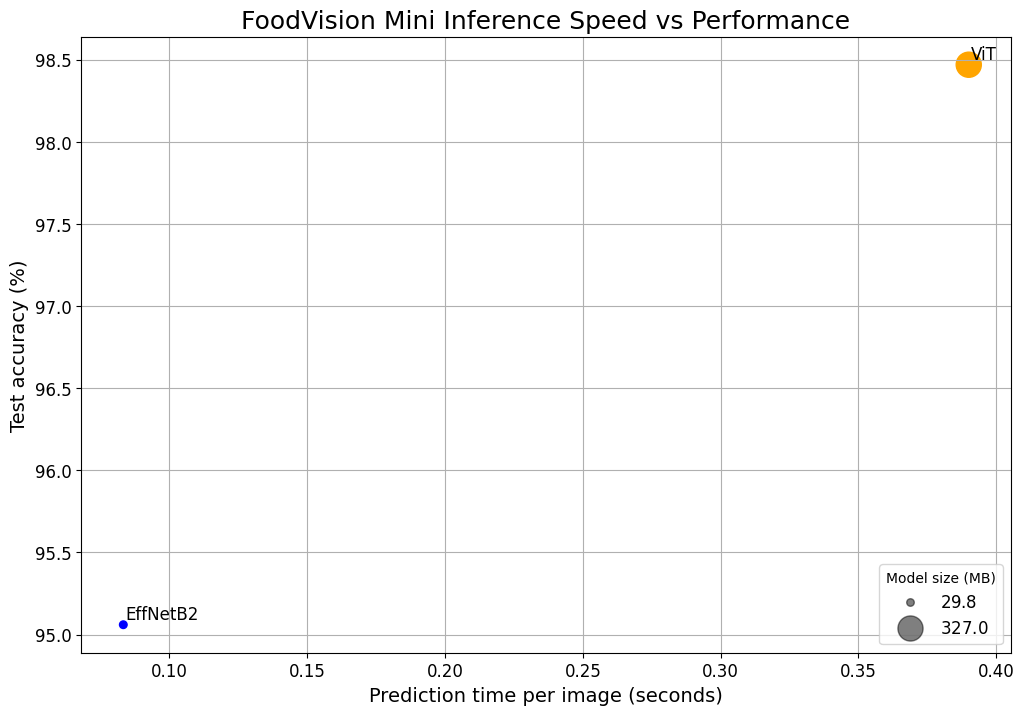

In [44]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df, 
                     x="time_per_pred_cpu", 
                     y="test_acc", 
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270 
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles, 
                              labels, 
                              loc="lower right", 
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
plt.savefig("images/09-foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

## EffnetB2 fulfills our criteria the most, therefore we are going to continue with this model

In [45]:
# import/install Gradio
try:
    import gradio as gr
except:
    !pip -q install gradio
    import gradio as gr

print(f'Gradio version: {gr.__version__}')

Gradio version: 4.24.0


## Gradio overview

Gradio helps you create macine learning demos.

## Create a function to map our inputs and outputs

In [46]:
effnetb2 = effnetb2.to('cpu')

next(iter(effnetb2.parameters())).device

device(type='cpu')

In [50]:
from typing import Tuple, Dict

def predict(img) -> Tuple[Dict, float]:
    # Start timere
    start_time = timer()
    # Transform the input image to for use with EffNetB2
    img = effnetb2_transforms(img).unsqueeze(0)
    # Put model into eval mode, make prediction
    effnetb2.eval()
    with pt.inference_mode():
        # Pass transformed image through the model and turn the predictions logits into probabilites
        pred_probs = pt.softmax(effnetb2(img), dim=1)
    # Create a prediction label and prediction probability dictionary
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate pred time
    end_time = timer()
    pred_time = round(end_time - start_time, 4)

    # Return pred dict and pred time
    return pred_labels_and_probs, pred_time

In [54]:
import random
from PIL import Image

# get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob('*/*.jpg'))
print(f'Example test data path: {test_data_paths[0]}')

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]
random_image_path

# Open the target image
image = Image.open(random_image_path)
print(f'[INFO] predicting on image at path: {random_image_path}\n')

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(pred_dict)
print(pred_time)

Example test data path: data\pizza_steak_sushi_20_percent\test\pizza\1001116.jpg
[INFO] predicting on image at path: data\pizza_steak_sushi_20_percent\test\pizza\2250611.jpg

{'pizza': 0.7598061561584473, 'steak': 0.051893945783376694, 'sushi': 0.18829986453056335}
0.1057


## Creating a list of example images

In [55]:
# Create list of image inputs to our gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data\\pizza_steak_sushi_20_percent\\test\\pizza\\420409.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\steak\\1482489.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\sushi\\715227.jpg']]

## Building a gradio inteface

In [62]:
# Create title, description, article
title = 'NutriVisionAI Mini'
description = 'An EfficientNetB2 feature extractor computer vision model to classify images as pizza, steak or sushi.'
article = "View the code in [The GitHub Repository](https://github.com/PWRXNDR/full_MLOps_cycle)"

# Create the gradio demo
demo = gr.Interface(fn=predict, 
                    inputs=gr.Image(type='pil'),
                    outputs=[gr.Label(num_top_classes=3, label='Predictions'),
                             gr.Number(label='Predictions time (s)')],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo
demo.launch(debug=False,
            share=True) # Generate a publically sharable url

Running on local URL:  http://127.0.0.1:7861

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


## Turning NutriVisionAI Mini gradion demo into a deployable app

## Creating demos folder to store our NutriVisionAI app files

In [63]:
import shutil
from pathlib import Path

# Create NutriVision mini demo path
nutrivision_mini_demo_path = Path('demos/nutrivision_mini/')
# remove files that might exist and create a new directory
if nutrivision_mini_demo_path.exists():
    shutil.rmtree(nutrivision_mini_demo_path)
    nutrivision_mini_demo_path.mkdir(parents=True,
                                     exist_ok=True)
else:
    nutrivision_mini_demo_path.mkdir(parents=True,
                                     exist_ok=True)

!ls demos/nutrivision_mini/

## Create a folder of example images to use with NutriVision Mini Demo

In [67]:
# Create an example directory
nutrivision_mini_examples_path = nutrivision_mini_demo_path / 'examples'
nutrivision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# Collect three random test dataset image paths
nutrivision_mini_examples = [Path('data\\pizza_steak_sushi_20_percent\\test\\pizza\\420409.jpg'),
                            Path('data\\pizza_steak_sushi_20_percent\\test\\steak\\1482489.jpg'),
                            Path('data\\pizza_steak_sushi_20_percent\\test\\sushi\\715227.jpg')]

# Copy the three images to the examples directory
for example in nutrivision_mini_examples:
    destination = nutrivision_mini_examples_path / example.name
    print(f'[INFO] Copying {example} to {destination}')
    shutil.copy2(src=example,
                 dst=description)

[INFO] Copying data\pizza_steak_sushi_20_percent\test\pizza\420409.jpg to demos\nutrivision_mini\examples\420409.jpg
[INFO] Copying data\pizza_steak_sushi_20_percent\test\steak\1482489.jpg to demos\nutrivision_mini\examples\1482489.jpg
[INFO] Copying data\pizza_steak_sushi_20_percent\test\sushi\715227.jpg to demos\nutrivision_mini\examples\715227.jpg


In [68]:
import os

# Get example filepaths in a list of lists
exmaple_list = [['examples/' + example] for example in os.listdir(nutrivision_mini_examples_path)]
example_list

[['data\\pizza_steak_sushi_20_percent\\test\\pizza\\420409.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\steak\\1482489.jpg'],
 ['data\\pizza_steak_sushi_20_percent\\test\\sushi\\715227.jpg']]

## Moving our trained EffNetB2 model to our NutriVision Mini Demo directory

In [70]:
# Create a source path for our target model
effnet2_nutrivision_mini_model_path = 'models/MLOps_effnetb2_pizza_steak_sushi.pth'

# Create a destination path for our target model
effnetb2_nutrivision_mini_model_destination = nutrivision_mini_demo_path / effnet2_nutrivision_mini_model_path.split('/')[1]

effnetb2_nutrivision_mini_model_destination

# Try to move the model file
try:
    print(f'[INFO] Attempting to move {effnet2_nutrivision_mini_model_path} to {effnetb2_nutrivision_mini_model_destination}')

    # Move model
    shutil.move(src=effnet2_nutrivision_mini_model_path,
                dst=effnetb2_nutrivision_mini_model_destination)

    print(f'[INFO] Model Move complete.')
    # if the model alrewady been moved, check if exists

except:
    print(f'[INFO] No model found at {effnet2_nutrivision_mini_model_path}, prehaps its already been moved?')
    print(f'[INFO] Model exists at {effnetb2_nutrivision_mini_model_destination}: {effnetb2_nutrivision_mini_model_destination.exists()}')

[INFO] Attempting to move models/MLOps_effnetb2_pizza_steak_sushi.pth to demos\nutrivision_mini\MLOps_effnetb2_pizza_steak_sushi.pth
[INFO] Model Move complete.


In [71]:
%%writefile demos/nutrivision_mini/model.py
import torch as pt
import torchvision

from torch import nn

def create_effnetb2_model(num_classes:int=3,
                          seed:int=42):

    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    for param in model.parameters():
        param.requires_grad = False

    pt.manual_seed(seed)
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408,
                  out_features=num_classes)
    )
    return model, transforms

Writing demos/nutrivision_mini/model.py


In [72]:
from demos.nutrivision_mini import model

effnetb2_model, effnetb2_transforms_import = model.create_effnetb2_model()
effnetb2_model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## Turning Nutrivision mini gradio app into a python script `app.py`

In [85]:
%%writefile demos/nutrivision_mini/app.py
import gradio as gr
import os
import torch as pt

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
class_names = ['pizza', 'steak', 'sushi']

# Model and transforms preparation
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=3)

# Load save weights
effnetb2.load_state_dict(
    pt.load(
        f='MLOps_effnetb2_pizza_steak_sushi.pth',
        map_location=pt.device('cpu')
    )
)

# Predict function
def predict(img) -> Tuple[Dict, float]:
    # Start timere
    start_time = timer()
    # Transform the input image to for use with EffNetB2
    img = effnetb2_transforms(img).unsqueeze(0)
    # Put model into eval mode, make prediction
    effnetb2.eval()
    with pt.inference_mode():
        # Pass transformed image through the model and turn the predictions logits into probabilites
        pred_probs = pt.softmax(effnetb2(img), dim=1)
    # Create a prediction label and prediction probability dictionary
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate pred time
    end_time = timer()
    pred_time = round(end_time - start_time, 4)

    # Return pred dict and pred time
    return pred_labels_and_probs, pred_time

# Create title, description and article
title = 'NutriVisionAI Mini'
description = 'An EfficientNetB2 feature extractor computer vision model to classify images as pizza, steak or sushi.'
article = "View the code in [The GitHub Repository](https://github.com/PWRXNDR/full_MLOps_cycle)"

# Function to check if a file is an image
def is_image(file_name):
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.gif', '.tiff', '.webp']  # Add other image extensions if needed
    return any(file_name.lower().endswith(ext) for ext in image_extensions)

# Create example list with image files only
example_list = [['examples/' + example] for example in os.listdir('examples') if is_image(example)]

# Create Gradio demo
demo = gr.Interface(fn=predict, 
                    inputs=gr.Image(type='pil'),
                    outputs=[gr.Label(num_top_classes=3, label='Predictions'),
                             gr.Number(label='Predictions time (s)')],
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch demo
demo.launch(debug=False)

Overwriting demos/nutrivision_mini/app.py


## Creating `requirements.txt`

In [74]:
print(f'Pytorch version: {pt.__version__}')
print(f'Torchvision version: {torchvision.__version__}')
print(f'Gradio version: {gr.__version__}')

Pytorch version: 2.2.1+cpu
Torchvision version: 0.17.1+cpu
Gradio version: 4.24.0


In [81]:
%%writefile demos/nutrivision_mini/requirements.txt
torch==2.2.1
torchvision==0.17.1
gradio==4.24.0

Overwriting demos/nutrivision_mini/requirements.txt


## Deploying our Nutrivision Mini to HugginFace space

In [76]:
!ls demos/nutrivision_mini

MLOps_effnetb2_pizza_steak_sushi.pth
__pycache__
app.py
examples
model.py
requirements.txt


In [82]:
import shutil
import os

def make_archive(source_dir, output_filename, output_dir, ignore_patterns=[]):
    # Temporary directory to copy files that should be in the archive
    temp_dir = os.path.join(output_dir, 'temp')
    
    # Copy files, excluding the ones with patterns defined in ignore_patterns
    shutil.copytree(source_dir, temp_dir, ignore=shutil.ignore_patterns(*ignore_patterns))
    
    # Create archive from the temporary directory
    shutil.make_archive(os.path.join(output_dir, output_filename), 'zip', temp_dir)
    
    # Remove the temporary directory
    shutil.rmtree(temp_dir)

# Define the directory to be zipped
dir_to_zip = 'demos/nutrivision_mini'

# Define the output zip file name
output_filename = 'nutrivision_mini'

# Define the directory where to save the zip file
output_dir = 'demos'

# Define patterns to ignore
ignore_patterns = ['*.pyc', '*.ipynb', '__pycache__', '*.ipynb_checkpoints*']

# Create the zip file
make_archive(dir_to_zip, output_filename, output_dir, ignore_patterns)

## Uploading NutriVisionAI Mini Gradio demo to Hugging Face Spaces

In [ ]:
from IPython.display import IFrame

IFrame(src='https://hf.space/embed/pwrxndr/nutrivisionai_mini/+', width=900, height=750)